<a href="https://colab.research.google.com/github/sanjanams742/sanjanams742/blob/main/cyberbullying_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJECT TITLE: Cyberbullying Classification**

**Visualization and Prediction using NLP**

As social media usage becomes increasingly prevalent in every age group, a vast majority of citizens rely on this essential medium for day-to-day communication. Social media’s ubiquity means that cyberbullying can effectively impact anyone at any time or anywhere, and the relative anonymity of the internet makes such personal attacks more difficult to stop than traditional bullying.

On April 15th, 2020, UNICEF issued a warning in response to the increased risk of cyberbullying during the COVID-19 pandemic due to widespread school closures, increased screen time, and decreased face-to-face social interaction. The statistics of cyberbullying are outright alarming: 36.5% of middle and high school students have felt cyberbullied and 87% have observed cyberbullying, with effects ranging from decreased academic performance to depression to suicidal thoughts.

In light of all of this, this dataset contains more than 47000 tweets labelled according to the class of cyberbullying:

Age
Ethnicity
Gender
Religion
Other type of cyberbullying
Not cyberbullying

Trigger Warning: These tweets either describe a bullying event or are the offense themselves, therefore explore it to the point where you feel comfortable.

In this project, I'm going to analyze the tweets, plot some visualizations, process them with different NLP techniques like TFIDF and Word2Vec and finally evaluate predictions of various ML Classifiers and RNN.

Let's get started 😇

**Importing Libraries**

In [51]:
# Utility
import numpy as np
import pandas as pd
import pickle

# Plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


**Data Import**

In [54]:
df = pd.read_csv('/content/cyberbullying_tweets.csv')
display(df.sample(5))
df.shape

,tweet_text,cyberbullying_type
44589,Not just the leftist media but the white liber...,ethnicity
21672,Oh ! Then what is PAK ISIS attire for ? Raping...,religion
26949,"Thus far, unimpressed by Emerald Dream. Quests...",other_cyberbullying
39909,*Raheem Sterling scores the game winning penal...,ethnicity
23411,"Haha.. place where terrorists comes first, whe...",religion


(47692, 2)

We can see there are 47692 tweets in total.

In [55]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

They belong to 6 different classes, which are:

Age, Gender, Ethnicity, Religion, Other and Not Cyberbullying

In [56]:
for tweet in df.sample(5)['tweet_text']:
    print(tweet +'\n')

Sure! AMA is here: http://t.co/KKCSABHgzs // @mattjbaldo

She's beautiful. My grand daughter was bullied mercilessly for the last two years of high school. I told her she was a 'A swan' and that come prom night it would be like Cinderella. AND IT WAS. Nobody recognized her. She stayed above it all. My heart breaks for these girls. xxx

Not my middle school bully following me and liking my retweets, goodbye sister

rape, racist and gay jokes? Must've missed that interview https://twitter.com/condoradore/status/843410631466373120

@Salt_Npeppa lol!!! Nd I cyaa eat too much up ere cah u kno I going get fat b



This is what the tweets look like. Pretty toxic.

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [58]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


**Data Pre-processing**

 Are there any null or duplicate values?

In [59]:
df.isnull().sum()

,0
tweet_text,0
cyberbullying_type,0


In [60]:
df['tweet_text'].duplicated().sum()

1675

Let's drop these duplicated.

In [61]:
df.drop_duplicates('tweet_text', inplace=True, ignore_index=True)
df['tweet_text'].duplicated().sum()

0

Are the classes balanced?

In [62]:
df['cyberbullying_type'].value_counts()

,count
cyberbullying_type,
religion,7995
age,7992
ethnicity,7952
not_cyberbullying,7937
gender,7898
other_cyberbullying,6243


Looks pretty balanced.

Since the other_cyberbullying class is too generic, contains many categories in itself and brings down the accuracies of the upcoming prediction models, I have decided to remove it and work with the remaining classes.

In [63]:
df = df[df["cyberbullying_type"] != "other_cyberbullying"]
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity'],
      dtype=object)

Label Encoding the Classes




In [64]:
cyberbullying_type = ['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity']
encoding_dict = {'not_cyberbullying':0, 'gender':1, 'religion':2, 'age':3, 'ethnicity':4}
df['cyberbullying_type'] = df['cyberbullying_type'].map(encoding_dict)
df.sample(5)

,tweet_text,cyberbullying_type
44634,"Don't put anything past them. They will cheat,...",4
39277,"ikr ive been called white by antis, locals, AN...",4
8998,"wowza, you managed to combine a rape joke with...",1
18705,"Anti-fascist: ""We don't want anyone to be in a...",2
3162,@Palestine_UN @isra_jourisra They were connect...,0


NLP Processing

Time to clean the tweets and process them to a new column.

In [65]:
# Downloading dependencies
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [66]:
stopwords_list = stopwords.words('english')
additional_stopwords = ['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's']   # Specific to twitter lingo
stopwords_list.extend(additional_stopwords)
lemmatizer = WordNetLemmatizer()    # Using Lemmatizer instead of Stemmer

Below are the custom defined functions to deep clean the unprocessed tweets.
Their identifier names describe their working.

In [67]:
def remove_usernames(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='@']
    return ' '.join(words)

def remove_hashtags(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='#']
    return ' '.join(words)

def remove_links(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[:4]!='http']
    return ' '.join(words)

def remove_punctuation(tweet):
    for mark in punctuation:
        tweet = tweet.replace(mark, '')
    return tweet

def convert_lowercase(tweet):
    return tweet.lower()

def tokenization(tweet):
    return word_tokenize(tweet)

def remove_stopwords(tok_tweet):
    res = []
    for word in tok_tweet:
        if word not in stopwords_list:
            res.append(word)
    return res

def lemmatize_words(tok_tweet):
    res = []
    for word in tok_tweet:
        res.append(lemmatizer.lemmatize(word))
    return res

In [68]:
# Defining a custom tweet cleaning function
def pre_processing_custom(tweet):
    tweet = remove_usernames(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_links(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

Time to apply this processing function to our dataset.

In [69]:

df['clean_tweets'] = df['tweet_text'].map(pre_processing_custom)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets
2217,@everymadness -.-idk hw to do...,0,idk hw
9484,RT @finicalgal: Nicki explains the complexitie...,1,nicki explains complexity catwalk modelling pl...
6636,@4for4_Josh @mstrbass2000 I drafted Charles wi...,0,drafted charles 9th pick first round
15426,@PouyaSaz1 yes??? the guys on my TL bashing ga...,1,yes guy tl bashing gay marriage one tweet rape...
16927,Not all muslims are from islam you idiot,2,muslim islam idiot


The clean_tweets column holds the processed tweets.

It's nice and does the job, but we can do much better cleaning by using pre-defined functions and RegEx.
Therefore, I'm using the tweet-preprocessor library, as shown below.

In [70]:
!pip install tweet-preprocessor
import preprocessor as p

In [71]:
def clean_tweets(tweet):
    tweet = p.clean(tweet)
    return tweet

It takes care of all the URLs, Hashtags, Mentions, Reserved Words, Emojis and Smileys.

In [72]:
# Defining the better cleaning function
def pre_processing(tweet):
    tweet = clean_tweets(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

In [73]:
# Clean tweets
df['clean_tweets'] = df['tweet_text'].map(pre_processing)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets
30738,Mine was mostly school bullies and total stran...,3,mine mostly school bully total stranger street...
19822,@StrangerOnFire @onzelfzuchtig @Raqqa_Sl Pacif...,2,pacificim solution hindu tried muslim slaughte...
31477,"These 'smert, Kool' girls who used to bully me...",3,smert kool girl used bully thinking unkool dum...
42058,Dumb ass nigger fuck you be pissin me offf,4,dumb as nigger fuck pissin offf
12474,"Yes, rape jokes are the pinnacle of comedy, da...",1,yes rape joke pinnacle comedy dad oh totally d...


Checking again if any values got duplicated.

In [74]:
df['clean_tweets'].duplicated().sum()

1215

Removing them all.

In [75]:
df.drop_duplicates('clean_tweets', inplace=True, ignore_index=True)
df['clean_tweets'].duplicated().sum()

0

38557 tweets are remaining.

Now that we have processed the tweets, it's time to move forward and calculate the total and average word lengths of each tweet.

In [76]:
df.shape

(38559, 3)

In [77]:
# Total word count of a tweet
df['word_count'] = df['tweet_text'].map(lambda x: len(x.split()))
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets,word_count
10847,murders gays and in the same breath turns a th...,1,murder gay breath turn threat nuclear holocaus...,23
4397,@BRYAN_521 Please go like the facebook page to...,0,please go like facebook page help stop bullying,12
24921,"The online bullies whipped themselves up. One,...",3,online bully whipped one found lived hometown ...,45
18909,"among the right, against certain groups. It's ...",2,among right certain group hate based fear base...,51
33094,My job really think I don’t know the slick shi...,4,job really think dont know slick shit tryna pu...,28


In [78]:
#import pandas as pd
#from google.colab import files

# Save the DataFrame to a CSV file in the Colab environment
#df.to_csv('cleaned_dataset.csv', index=False)

# Download the file to your local system
#files.download('cleaned_dataset.csv')

In [79]:
# Average word length of a tweet
def avg_word_length(tweet):
    words = tweet.split()
    word_count = len(words)
    word_length = 0
    for word in words:
        word_length += len(word)
    avg_length = round(word_length / word_count,2)
    return avg_length

df['avg_word_length'] = df['tweet_text'].map(avg_word_length)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets,word_count,avg_word_length
27889,I rolled two inside of three hours. Sixth grad...,3,rolled two inside three hour sixth grade last ...,48,4.77
20007,Sure it will be free of islamic terrorism and ...,2,sure free islamic terrorism china keep watchin...,35,4.11
30595,Because he was mad at and jealous of Dr Fauci ...,3,mad jealous dr fauci tried lie oneup like elem...,23,3.87
9328,"@StJ51 the same way that Rape jokes, and Race ...",1,way rape joke race joke holocaust joke gay jok...,22,4.59
18496,This is part of the problem. People making dum...,2,part problem people making dumbass comparison ...,46,4.76


We can also remove the outliers and the tweets useless to us from this dataset, like this

In [80]:
df = df[df['word_count']>3]
df = df[df['word_count']<100]
df.reset_index(drop=True, inplace=True)
df.shape

(38202, 5)

In [81]:
import nltk.sentiment
nltk.download('vader_lexicon')

def get_score(input_text):
    analyzer = nltk.sentiment.SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(input_text)
    sentiment_score = scores['compound']
    return sentiment_score

def get_reaction(score):
    if(score > 0.5):
        return 'Highly Positive'
    if(score > 0):
        return 'Positive'
    if(score == 0):
        return 'Neutral'
    if(score < -0.5):
        return 'Highly Negative'
    if(score < 0):
        return 'Negative'

def main():
    input_text = input("Please enter a sentence : ")
    score = get_score(input_text)
    reaction = get_reaction(score)
    print('Sentiment score : ', score)
    print(reaction)
if __name__ == "__main__":
    main()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Please enter a sentence : bitch ass hole 
Sentiment score :  -0.8074
Highly Negative


**Data Visualization**

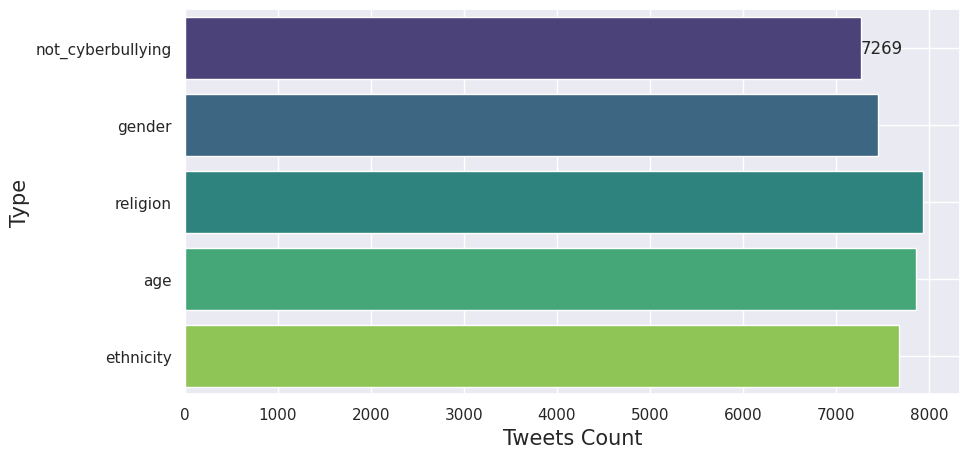

In [82]:
sns.set_theme()
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, y='cyberbullying_type', palette="viridis")
ax.bar_label(ax.containers[0])
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Tweets Count', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

All the classes look balanced.

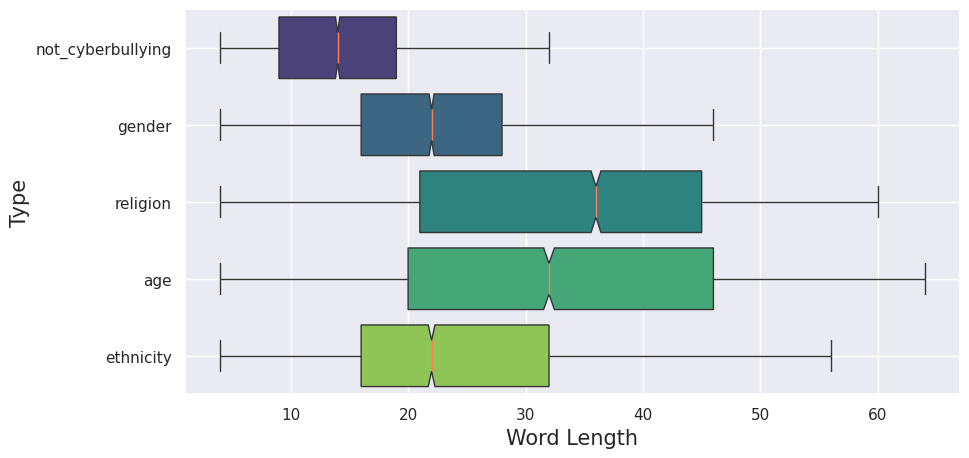

In [83]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='cyberbullying_type', x='word_count', orient='h', showfliers=False,
            palette='viridis', notch=True, medianprops={"color": "coral"})  # Using 'word_count' column for x-axis
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Word Length', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

We can observe that the tweets targeted towards a gender tend to have a bit less words in them than say, the ones targeted towards religion.
But overall, a bullying tweet has more words in it and is more varied than a normal one.

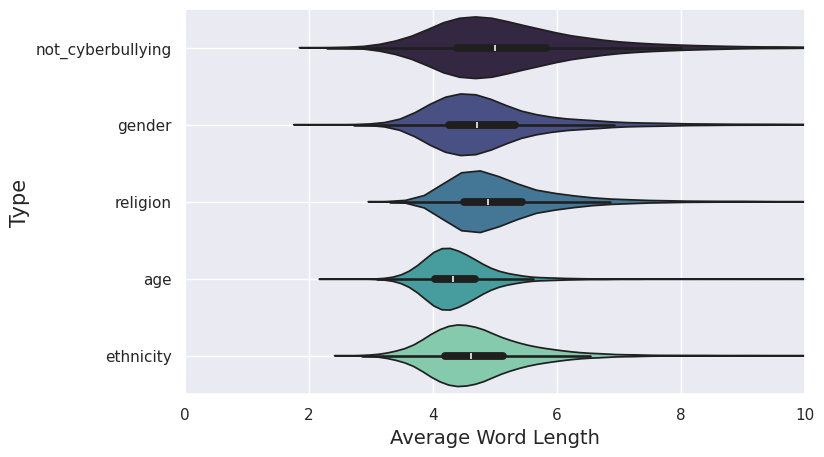

In [84]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, y='cyberbullying_type', x='avg_word_length', orient='h', palette='mako')
plt.xlim(0, 10)
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Average Word Length', size=14)
plt.ylabel('Type', size=15)
plt.grid(color='w')

Pretty much the same for all, between 4 to 6 letters.

Text(32.0, 0.5, 'Average Word Length')

<Figure size 800x500 with 0 Axes>

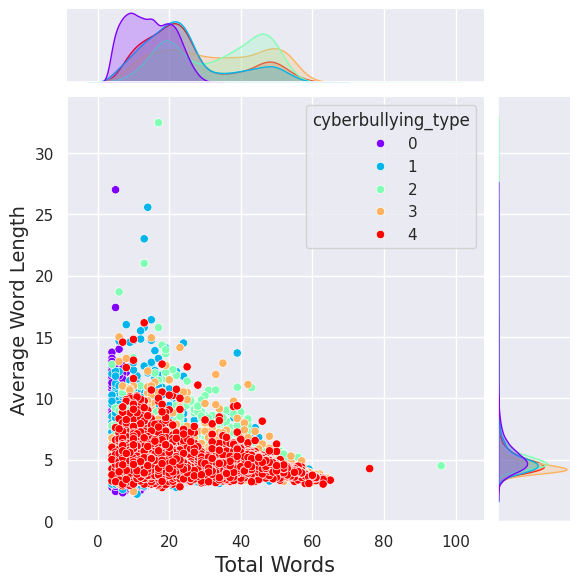

In [85]:
plt.figure(figsize=(8, 5))
sns.jointplot(data=df, y='avg_word_length', x='word_count', hue='cyberbullying_type', palette='rainbow')
plt.xlabel('Total Words', size=15)
plt.ylabel('Average Word Length', size=14)

**Word Clouds**

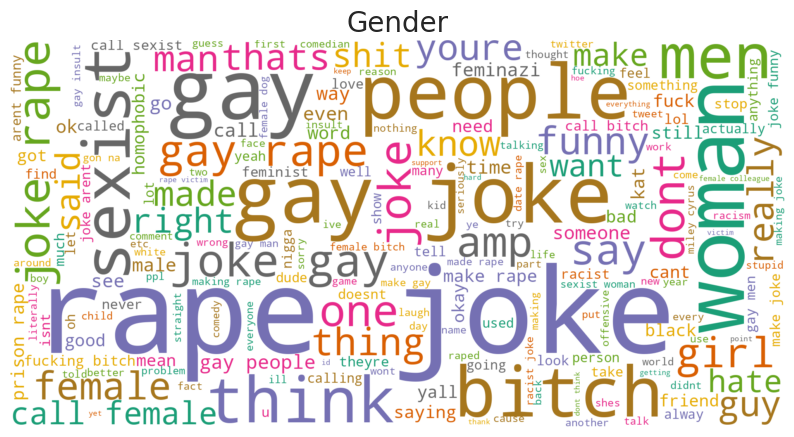

In [86]:
# Gender
plt.figure(figsize=(10, 10))
subset1 = df[df['cyberbullying_type']==1]
text_gender = subset1['clean_tweets'].values
wc1 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_gender))
plt.axis('off')
plt.title("Gender", fontsize=20)
plt.imshow(wc1, interpolation='bilinear')

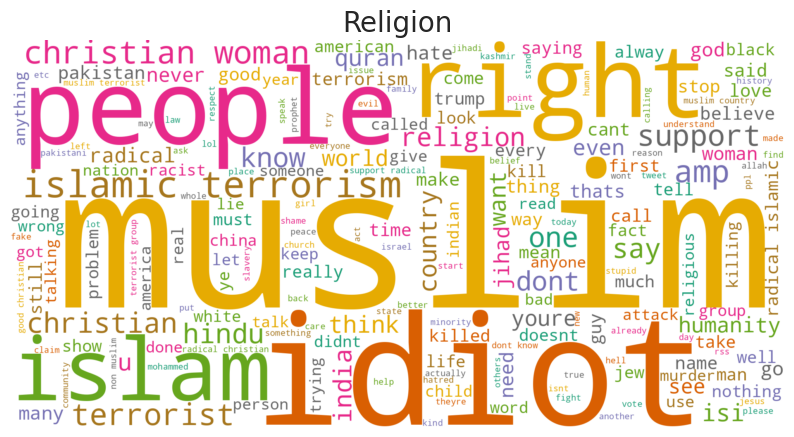

In [50]:
# Religion
plt.figure(figsize=(10, 10))
subset2 = df[df['cyberbullying_type']==2]
text_religion = subset2['clean_tweets'].values
wc2 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_religion))

plt.axis('off')
plt.title("Religion", fontsize=20)
plt.imshow(wc2, interpolation='bilinear')

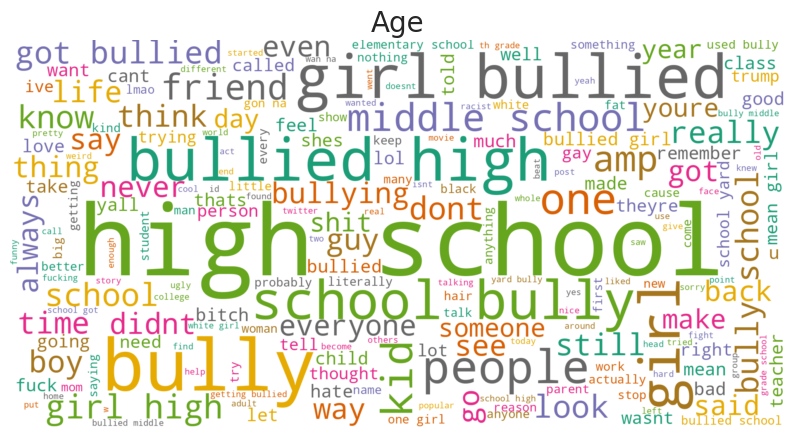

In [87]:
# Age
plt.figure(figsize=(10, 10))
subset3 = df[df['cyberbullying_type']==3]
text_age = subset3['clean_tweets'].values
wc3 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_age))

plt.axis('off')
plt.title("Age", fontsize=20)
plt.imshow(wc3, interpolation='bilinear')

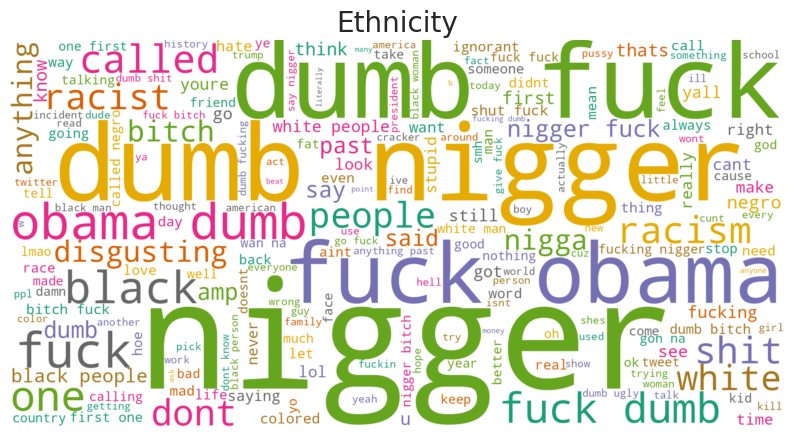

In [88]:
# Ethnicity
plt.figure(figsize=(10, 10))
subset4 = df[df['cyberbullying_type']==4]
text_ethnicity = subset4['clean_tweets'].values
wc4 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_ethnicity))

plt.axis('off')
plt.title("Ethnicity", fontsize=20)
plt.imshow(wc4, interpolation='bilinear')

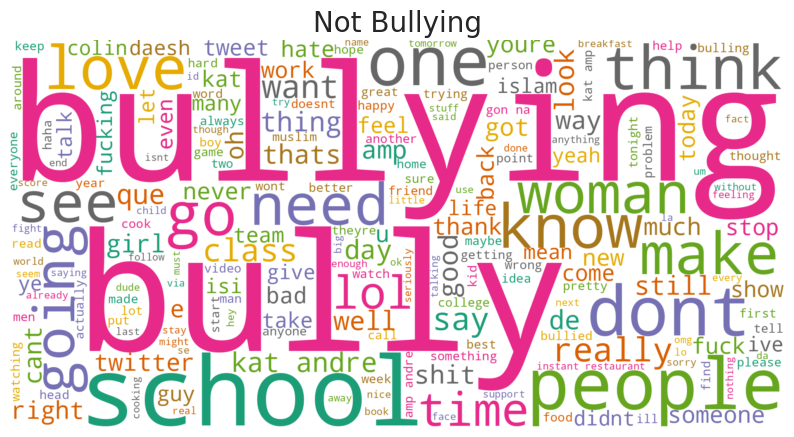

In [89]:
# Not Bullying
plt.figure(figsize=(10, 10))
subset0 = df[df['cyberbullying_type']==0]
text_not = subset0['clean_tweets'].values
wc0 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_not))

plt.axis('off')
plt.title("Not Bullying", fontsize=20)
plt.imshow(wc0, interpolation='bilinear')

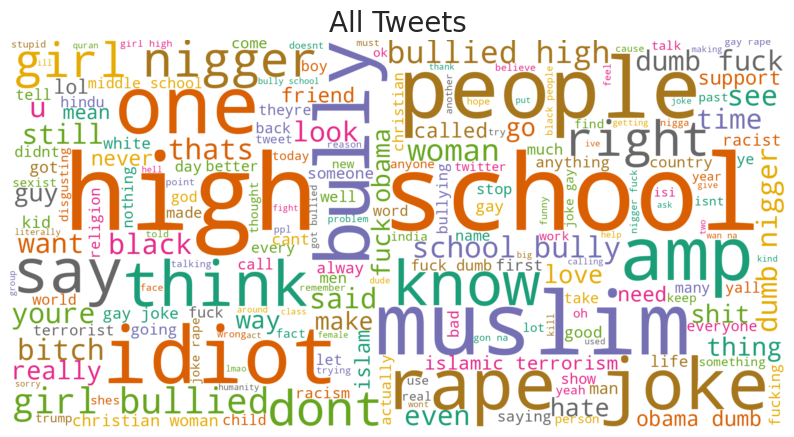

In [90]:
# All Tweets
plt.figure(figsize=(10, 10))
text_all = df['clean_tweets'].values
wc = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_all))

plt.axis('off')
plt.title("All Tweets", fontsize=20)
plt.imshow(wc, interpolation='bilinear')

Now that we're done with the wordclouds, let's check which words are the most popular.

In [91]:
from collections import Counter   # To count the frequency of each word

temp=[]
for tweet in df['clean_tweets']:
  for word in tweet.split():
    temp.append(word)
vocab = Counter(temp)
print("Vocabulary Size:", len(vocab))
print(list(vocab.items())[:5])

Vocabulary Size: 38477
[('word', 867), ('food', 128), ('crapilicious', 1), ('white', 2213), ('classy', 29)]


vocab contains the frequency of all the unique words in the whole dataset. Pretty interesting.
Let's try to plot it and see what we get.

In [92]:
common_word=[]
freq=[]
for i, j in vocab.most_common()[:10]:
  common_word.append(i)
  freq.append(j)

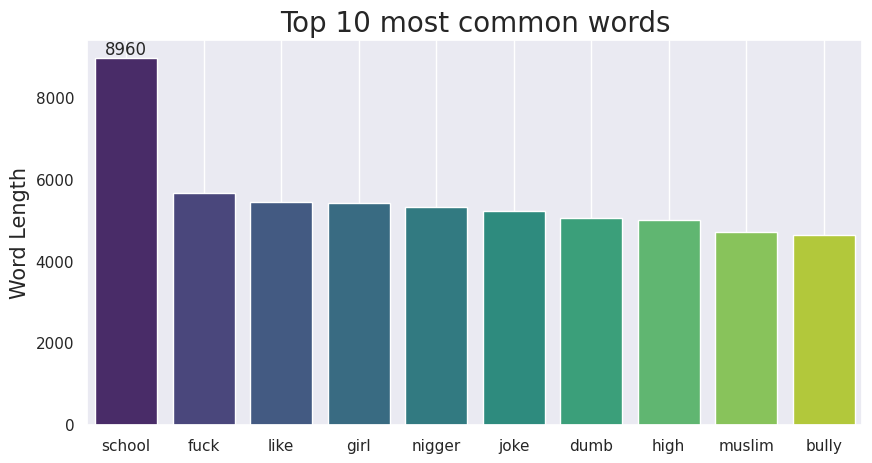

In [93]:
# Most common words
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=common_word, y=freq, palette='viridis')
plt.title('Top 10 most common words', size=20)
ax.bar_label(ax.containers[0])
plt.ylabel("Word Length", size=15)
plt.grid()

In [94]:
from transformers import pipeline

# Load pre-trained emotion detection model
emotion_model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

# Function to detect emotions
def detect_emotions(texts):
    # Pass the input text to the model
    predictions = emotion_model(texts)

    # Collect emotions and scores
    results = []
    for i, prediction in enumerate(predictions):
        emotions = {item['label']: item['score'] for item in prediction}
        sorted_emotions = sorted(emotions.items(), key=lambda x: x[1], reverse=True)
        results.append({
            "text": texts[i],
            "top_emotion": sorted_emotions[0][0],  # Most likely emotion
            "emotion_scores": emotions             # All emotions with their respective scores
        })
    return results

# Test the function with some sample texts
texts = [
    "feeling perturbed woman arent humble kindly go set fire"
    "Rebecca Black Drops Out of School Due to Bullying",
    "meh thanks head concerned another angry dude twitter",
    "This is so frustrating and annoying!",
    "Wow, I'm really surprised by this amazing news!",
    "I'm feeling anxious about tomorrow."
]

# Get emotion predictions
emotion_results = detect_emotions(texts)

# Display the results
for result in emotion_results:
    print(f"Text: {result['text']}")
    print(f"Top Emotion: {result['top_emotion']}")
    print(f"Emotion Scores: {result['emotion_scores']}")
    print("-" * 50)


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


Text: feeling perturbed woman arent humble kindly go set fireRebecca Black Drops Out of School Due to Bullying
Top Emotion: anger
Emotion Scores: {'anger': 0.543510913848877, 'disgust': 0.0019751847721636295, 'fear': 0.41835156083106995, 'joy': 0.0016235547373071313, 'neutral': 0.0023343719076365232, 'sadness': 0.02290879562497139, 'surprise': 0.009295647032558918}
--------------------------------------------------
Text: meh thanks head concerned another angry dude twitter
Top Emotion: anger
Emotion Scores: {'anger': 0.892951488494873, 'disgust': 0.011496661230921745, 'fear': 0.008162220939993858, 'joy': 0.006634408608078957, 'neutral': 0.035740308463573456, 'sadness': 0.026713896542787552, 'surprise': 0.018301082774996758}
--------------------------------------------------
Text: This is so frustrating and annoying!
Top Emotion: anger
Emotion Scores: {'anger': 0.735739529132843, 'disgust': 0.14240741729736328, 'fear': 0.005128467921167612, 'joy': 0.0025534441228955984, 'neutral': 0.018

**ML Classifiers**

Now that we have analyzed and visualized the dataset, had some reality check after seeing the wordclouds, its time to get our hands dirty and apply various ML classifiers to it, and see which one performs the best.

First, we start by splitting the data into train and test.

In [95]:
X = df['clean_tweets']
y = df['cyberbullying_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=76)

TF-IDF Vectorization

In [96]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)    # Fit on train
print("No. of feature words:", len(tfidf.get_feature_names_out()))

No. of feature words: 291954


In [97]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)
print(f"{X_train_tf.shape = }\n{X_test_tf.shape = }")

X_train_tf.shape = (30561, 291954)
X_test_tf.shape = (7641, 291954)


We're ready now, time to apply the models.

**Logistic Regression**

In [98]:
# Model training
lr = LogisticRegression(solver='saga', penalty='l2', random_state=394)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=394, solver='saga')

In [99]:
# Model prediction
y_pred_train = lr.predict(X_train_tf)
y_pred_test = lr.predict(X_test_tf)

Our Logistic Regression Model is ready, let's evaluate it.

In [100]:
# Model evaluation
print('\tClassification Report for Logistic Regression on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Logistic Regression on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Logistic Regression on Train

                    precision    recall  f1-score   support

not_cyberbullying       0.88      0.95      0.91      5815
           gender       0.98      0.91      0.94      5958
         religion       0.98      0.98      0.98      6350
              age       0.98      0.99      0.98      6292
        ethnicity       0.99      0.99      0.99      6146

         accuracy                           0.96     30561
        macro avg       0.96      0.96      0.96     30561
     weighted avg       0.96      0.96      0.96     30561


	Classification Report for Logistic Regression on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.80      0.79      0.80      1454
           gender       0.93      0.85      0.89      1490
         religion       0.95      0.95      0.95      1587
              age       0.92      0.99      0.95      1573
        ethnicity       0.96      0.99      0.97      

The performance scores of the algorithm are very good, with an overall accurcy of 92%.
We can observe how the predictions for the classes have very high F1 scores, while for the class "non-cyberbullying" the score is much lower.

Text(0.5, 1.0, 'Confusion Matrix LR')

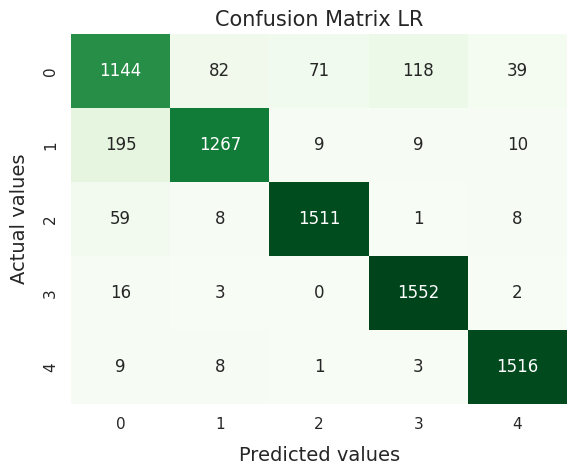

In [101]:
# Confusion Matrix for Logistic Regression
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix LR', size=15)

Let's try to predict on other models also, then we can compare.

**Naive-Bayes**

In [102]:
# Model training
mnb = MultinomialNB(alpha=0.1)
mnb.fit(X_train_tf, y_train)

MultinomialNB(alpha=0.1)

In [103]:
# Model prediction
y_pred_train = mnb.predict(X_train_tf)
y_pred_test = mnb.predict(X_test_tf)

In [104]:
# Model evaluation
print('\tClassification Report for Naive-Bayes\' on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Naive-Bayes\' on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Naive-Bayes' on Train

                    precision    recall  f1-score   support

not_cyberbullying       1.00      0.97      0.98      5815
           gender       1.00      0.99      0.99      5958
         religion       0.99      1.00      0.99      6350
              age       0.99      1.00      0.99      6292
        ethnicity       0.99      1.00      1.00      6146

         accuracy                           0.99     30561
        macro avg       0.99      0.99      0.99     30561
     weighted avg       0.99      0.99      0.99     30561


	Classification Report for Naive-Bayes' on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.89      0.47      0.61      1454
           gender       0.86      0.85      0.86      1490
         religion       0.84      0.97      0.90      1587
              age       0.79      0.98      0.87      1573
        ethnicity       0.89      0.93      0.91      1537

        

This clearly looks like a case of overfitting, or high variance, and Naive-Bayes' is famous for it.
Again we can see the 'not_cyberbullying' class performing worst, as it's too generic.

Let's see if we could resolve this issue in the next model, i.e., Random Forest.

Text(0.5, 1.0, 'Confusion Matrix NB')

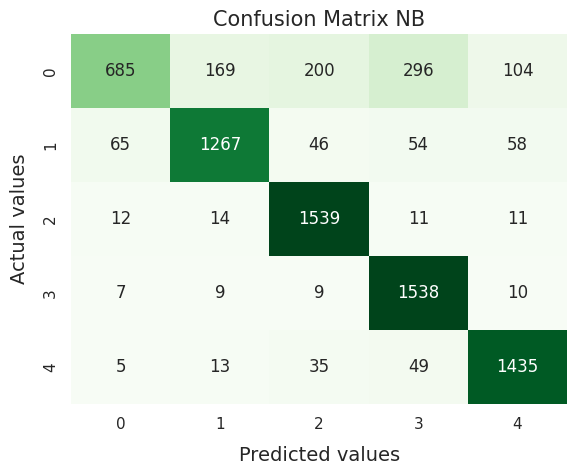

In [105]:
# Confusion Matrix for Naive-Bayes'
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix NB', size=15)

**Random Forest**

In [106]:
# Model training
rf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=30, random_state=27)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(criterion='entropy', max_depth=30, random_state=27)

Applied hyperparameter tuning using GridSearchCV below to find the best parameters for our model.

I've commented this block out as it takes too much time to run.
From here we can get the best parameters to use with Random Forest. I've applied them already.

In [107]:
# Model prediction
y_pred_train = rf.predict(X_train_tf)
y_pred_test = rf.predict(X_test_tf)

It did reduce the overfitting issue and gave an impressive accuracy of 90% also.

In [108]:
# Model evaluation
print('\tClassification Report for Random Forest on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Random Forest on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Random Forest on Train

                    precision    recall  f1-score   support

not_cyberbullying       0.76      0.92      0.84      5815
           gender       0.98      0.77      0.86      5958
         religion       0.96      0.96      0.96      6350
              age       0.97      0.98      0.97      6292
        ethnicity       0.98      0.98      0.98      6146

         accuracy                           0.92     30561
        macro avg       0.93      0.92      0.92     30561
     weighted avg       0.93      0.92      0.92     30561


	Classification Report for Random Forest on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.74      0.88      0.81      1454
           gender       0.97      0.76      0.85      1490
         religion       0.95      0.94      0.94      1587
              age       0.95      0.97      0.96      1573
        ethnicity       0.96      0.97      0.97      1537

      

Text(0.5, 1.0, 'Confusion Matrix RF')

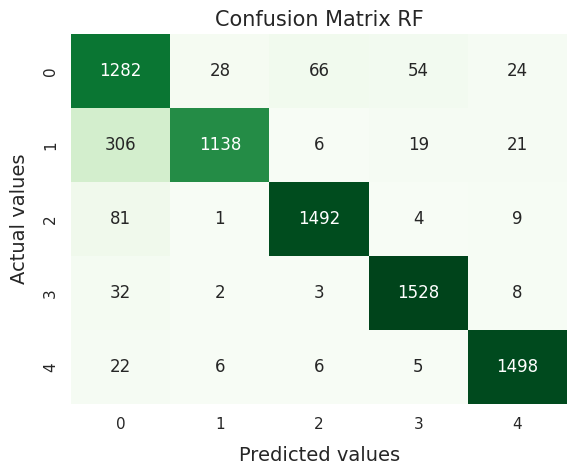

In [109]:
# Confusion Matrix for Random Forest
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix RF', size=15)

So far, Logistic Regression has performed the best with an amazing 92% accuracy.
Random Forest coming in at a close second with 90% accuracy overall.

Ensemble

We're going to use Voting technique here to aggregate the predictions, in order to improve the performance of our model.

In [110]:
# Model Training
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier(estimators = [('lr', lr), ('mnb', mnb), ('rf', rf)], voting='soft')
vot.fit(X_train_tf, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=394,
                                                 solver='saga')),
                             ('mnb', MultinomialNB(alpha=0.1)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=30,
                                                     random_state=27))],
                 voting='soft')

In [111]:
# Model prediction
y_pred_train = vot.predict(X_train_tf)
y_pred_test = vot.predict(X_test_tf)

In [112]:
# Model evaluation
print('\tClassification Report for Voting on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Voting on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Voting on Train

                    precision    recall  f1-score   support

not_cyberbullying       0.99      0.98      0.98      5815
           gender       1.00      0.99      0.99      5958
         religion       0.99      1.00      0.99      6350
              age       0.99      1.00      0.99      6292
        ethnicity       1.00      1.00      1.00      6146

         accuracy                           0.99     30561
        macro avg       0.99      0.99      0.99     30561
     weighted avg       0.99      0.99      0.99     30561


	Classification Report for Voting on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.86      0.70      0.77      1454
           gender       0.91      0.86      0.89      1490
         religion       0.91      0.98      0.94      1587
              age       0.89      0.99      0.94      1573
        ethnicity       0.95      0.98      0.96      1537

         accuracy   

As good as it can get. 91% accuracy on test data. We're using this model for all our future predictions.

Text(0.5, 1.0, 'Confusion Matrix Voting')

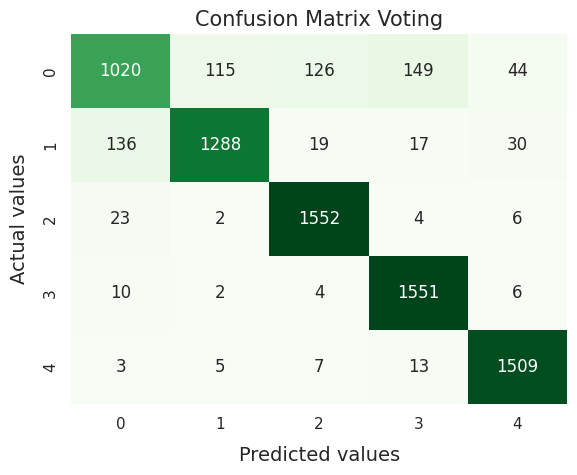

In [113]:
# Confusion Matrix after Voting
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix Voting', size=15)

Except 'not_bullying', all of our classes have been predicted well, with over 90% accuracy.

Now our final task is to get our model up and running, and use it to predict on some random texts.

**Model Saving, Loading and Prediction**

We can save our model, so it can be used whenever we require.
Here I have used pickle library for saving and loading.

In [114]:
# Saving Logistic Regression Model
model_file = open('LogisticRegression.pickle','wb')
pickle.dump(lr, model_file)
model_file.close()

# Saving Naive-Bayes' Model
model_file = open('NaiveBayes.pickle','wb')
pickle.dump(mnb, model_file)
model_file.close()

# Saving Random Forest Model
model_file = open('RandomForest.pickle','wb')
pickle.dump(rf, model_file)
model_file.close()

# Saving our final voting aggregated model
model_file = open('Voting.pickle','wb')
pickle.dump(vot, model_file)
model_file.close()

Prediction using saved model

In [115]:
# Defing our custom prediction function
def predict(model, texts):
    clean_texts = [pre_processing_custom(text) for text in texts]
    text_data = tfidf.transform(clean_texts)
    prediction = model.predict(text_data)

    data = []
    for text, prediction in zip(texts, prediction):
        data.append((text, prediction))

    df = pd.DataFrame(data, columns = ['text','type'])
    df = df.replace([0,1,2,3,4], cyberbullying_type)
    return df

Prediction

In [116]:
# Using our best model
model_file = open('Voting.pickle', 'rb')
model = pickle.load(model_file)
model_file.close()

# Providing some random toxic texts
texts = ["I hate you bitch",
        "School shooting. Haha dead.",
        "Treat them like black slaves",
        "I don't feel so good Mr. Potter",
        "christians are the worst"
        ]

#Our final prediction
predict(model, texts)

,text,type
0,I hate you bitch,gender
1,School shooting. Haha dead.,age
2,Treat them like black slaves,ethnicity
3,I don't feel so good Mr. Potter,not_cyberbullying
4,christians are the worst,religion


Even for a small sample of texts, our model is working perfectly and predicting as expected.